# Transformed Estimators

Whenever $x$ and $y$ are continuous and high-dimensional, estimating mutual information may require considerable resources.
Using the Data Processing Inequality (DPI), we can define a lower bound of mutual information by applying functions $f_x$ and $f_y$ to $x$ and $y$ respectively:
$$
I(x;y) \ge \max_{f_y \in \mathcal{F}_y} I(x;f_y(y)) \ge \max_{f_x\in \mathcal{F}_x, f_y \in \mathcal{F}_y} I(f_x(x);f_y(y))
$$

The functions $f_x$ and $f_y$ can be modeled via parametric neural network architectures which map structured high-dimensional data into lower-dimensional vector representations.



Here we will consider a simple example in which we will try to estimate mutual information between MNIST digits sampled from the same class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST


class PairedMNIST(Dataset):    
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.mnist = MNIST(*args, **kwargs)
        
    
    def __getitem__(self, idx):
        x, target = self.mnist[idx]
        idx_2 = np.random.choice(np.arange(len(dataset))[self.mnist.targets==target])
        y, target_2 = self.mnist[idx_2]
        assert target == target_2
        
        return {'x': x, 'y':y}
        
    def __len__(self):
        return self.mnist.__len__()
        
dataset = PairedMNIST('/data', transform=ToTensor())


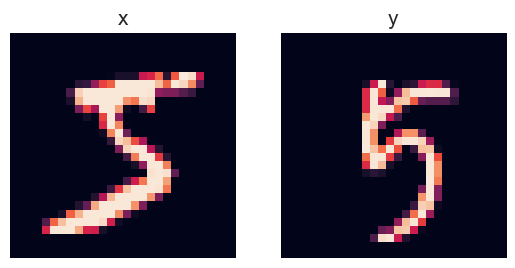

In [2]:
# Plot an example from the dataset
f, ax = plt.subplots(1,2)
ax[0].imshow(dataset[0]['x'][0])
ax[1].imshow(dataset[0]['y'][0])
ax[0].set_title('x', fontsize=15)
ax[1].set_title('y', fontsize=15)
ax[0].axis('off')
ax[1].axis('off');

Secondly we define a simple encoder architecture which maps the images of shape $[1 \times 28 \times 28]$ into a vector of shape [z_dim].

In [3]:
z_dim = 16

# Simple convolutional architecture with a flattening layer
encoder = nn.Sequential(
    nn.Conv2d(1, 16, 3),
    nn.ReLU(True),
    nn.Conv2d(16, 32, 5, stride=3),
    nn.ReLU(True),
    nn.Conv2d(32, 128, 8),
    nn.ReLU(True),
    nn.Flatten(),
    nn.Linear(128, z_dim)
)

Then, we can use the `TransformedMIEstimator` class to estimate mutual information between the encoded images using a mutual information estimation with provides valid gradient to update the encoder. Any discriminative estimator provides a valid lower-bound, which allows us to train the encoder together with the estimator.
Since the problem is symmetric in $x$ and $y$ we use the same encoder for both variables.

In the following example we use a simple 2-layer `SMILE` estimator with joint critic architecture and 8 negative samples for each pair of encoded $(f_x(x_i), f_y(y_i))$.

In [4]:
from torch_mist.estimators import TransformedMIEstimator, smile

transformed_estimator = TransformedMIEstimator(
    transforms={
        'x': encoder,
        'y': encoder,
    },
    base_estimator=smile(
        x_dim=z_dim,
        y_dim=z_dim,
        hidden_dims=[64, 32],
        neg_samples=32,
    )
)

transformed_estimator

TransformedMIEstimator(
  (base_estimator): SMILE(
    (ratio_estimator): JointCritic(
      (joint_net): DenseNN(
        (layers): ModuleList(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): Linear(in_features=64, out_features=32, bias=True)
          (2): Linear(in_features=32, out_features=1, bias=True)
        )
        (f): ReLU(inplace=True)
      )
    )
    (baseline): BatchLogMeanExp()
    (neg_samples): 32
  )
  (transforms): ModuleDict(
    (x->x): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 128, kernel_size=(8, 8), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=128, out_features=16, bias=True)
    )
    (y->y): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inpl

Lastly, we can train the estimator using the provided utilities and the custom dataset

In [5]:
from torch_mist.utils import train_mi_estimator

train_log = train_mi_estimator(
    transformed_estimator,
    train_data=dataset,
    max_epochs=10,
    verbose=True,
    lr_annealing=False,
    batch_size=128,
    num_workers=8,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/422 [00:00<?, ?it/s]

Using the weights from the last iteration


Since pairs of $x$ and $y$ are produced by considering data-points with the same label, we expect the mutual information value to approach $\ln 10$.

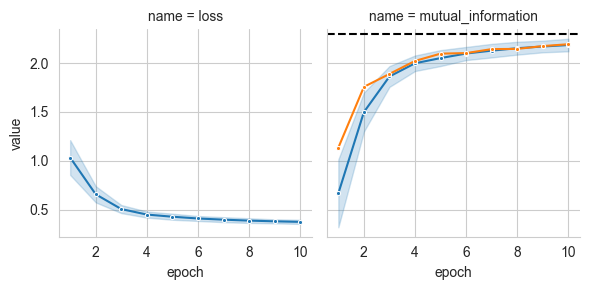

In [6]:
# Plot the estimated values of mutual information over time
grid = sns.FacetGrid(train_log, col='name', hue='split')

grid.map(sns.lineplot, 'epoch', 'value', marker='.', errorbar='sd', label='estimate')
grid.axes[0,1].axhline(y=np.log(10), ls='--', color='k', label='True $I(x;y)$')


Other than mutual information estimation, this setup can be used to train encoder for dimensionality reduction.
In fact, the encoder is essentially trained following the `InfoMax` principle:
$$
\mathcal{L}^{InfoMax}(\theta) = - I(f_\theta(x),f_\theta(y))
$$
Popular choices involve the use of `InfoNCE`, or `JS` (known as *DeepInfoMax*) for information maximization, but all discriminative estimators are supported in practice.

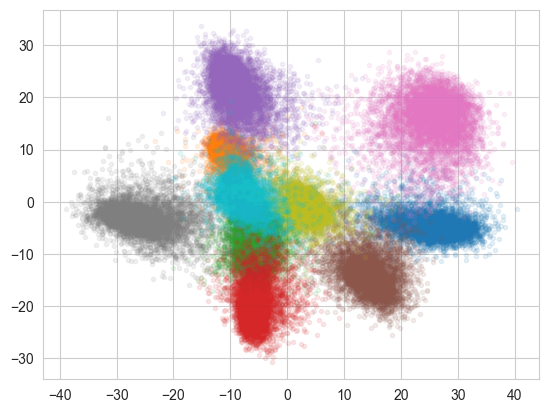

In [7]:
from sklearn.decomposition import PCA

# Compute the representation of all the images in the dataset with the trained encoder
zs = []

for data in DataLoader(dataset, batch_size=128):
    z = encoder(data['x'])
    zs.append(z)
zs = torch.cat(zs, 0).data.numpy()

# Project them to 2 dimensions using PCA
z_projected = PCA(2).fit_transform(zs)

# Plot them by label
for target in range(10):
    mask = dataset.mnist.targets==target
    plt.plot(z_projected[mask,0], z_projected[mask,1], '.', alpha=0.1)